In [1]:
import cycpd
import matplotlib.pyplot as plt
# import pycpd
import numpy as np
import os
import glob
import scipy
import shutil
import open3d as o3d
import time
import h5py
import utils
from utils import rotationMatrixToEulerAngles, voxelDownSample, fixedNumDownSample, farthestPointDownSample, showPointCloud, surfaceVertices2WatertightO3dMesh,\
    getEigValVecOfSSMByPCA, remainedInfoRatio, visualizeCompactnessOfSSM, saveAlignedPointGroups2Txt, loadAlignedPointGroupsWithIndex

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def zeroCentered(X):
    return X-np.mean(X,axis=0)

def getCorrePointPairs(X, Y):
    assert len(X) <= len(Y), "Num of point in X > Num of point in Y !"
    N = len(X)
    pointPairs = []
    dists = scipy.spatial.distance_matrix(X, Y, p=2, threshold=int(1e8))
    for i in range(N): #顺序贪婪（快）
        j = np.argmin(dists[i,:])
        pointPairs.append((i, j)) # i:ref index, j: mov index
        dists[:,j] = np.inf
    return np.array(pointPairs, dtype=np.uint32)

def extractCorreMovPoints(pMov, pointPairs):
    return pMov[pointPairs[:,1], :]

## pycpd/cycpd registration test

In [3]:
# files = glob.glob(os.path.join(r"F:\Smartee\data\cpdAlignedData\16", "1*.txt"))
# files = glob.glob(os.path.join(r"F:\Smartee\data-refined\repaired-txt\17", "*.txt"))
# files = glob.glob(os.path.join(r"F:\Smartee\data\ssa-repaired-txt\41", "2*.txt"))
# Xs = [np.loadtxt(f) for f in files]
# for x,f in zip(Xs,files):
#     showPointCloud(x, f)

In [3]:
# kwargs = {'iteration': self.iteration,'error': self.q, 'X': self.X, 'Y': self.TY}
def callbackOnIteration(iteration, error, X, Y):
    print("iteration: {}, error: {}.".format(iteration,error))

X = np.loadtxt(r".\data\ssa-repaired-txt\11\27U.txt")
# X = fixedNumDownSample(X, desiredNumOfPoint=1500, leftVoxelSize=0.7, rightVoxelSize=0.1)
X = farthestPointDownSample(X, 1500)
Y = np.loadtxt(r".\data\ssa-repaired-txt\11\28U.txt")
Y = farthestPointDownSample(Y, 3000)
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (1500, 3)
Y shape:  (3000, 3)


In [4]:
# X = zeroCentered(X)
# Y = zeroCentered(Y)
tic = time.time()
# reg = pycpd.RigidRegistration(**{'X': X, 'Y': Y, 'max_iterations':100,'tolerance':1e-4})
# TY,(s,r,t) = reg.register(callback=callbackOnIteration)
reg = cycpd.rigid_registration(**{'X': X, 'Y': Y, 'max_iterations':100,'tolerance':1e-4,'verbose':True,'print_reg_params':True})
TY,(s,r,t) = reg.register()
toc = time.time()
print("elapsed time:{:.4f} s".format(toc-tic))

Iteration:1
ML: -5100.622; 	ML change (error):  5100.622; 	Sigma^2:     3.770; 	Sigma^2 change:     6.318
[                                                                        ]
Iteration:2
ML: -6392.064; 	ML change (error):  1291.442; 	Sigma^2:     3.538; 	Sigma^2 change:     0.232
[=                                                                       ]
Iteration:3
ML: -6417.507; 	ML change (error):    25.443; 	Sigma^2:     3.303; 	Sigma^2 change:     0.235
[==                                                                      ]
Iteration:4
ML: -6445.311; 	ML change (error):    27.804; 	Sigma^2:     3.021; 	Sigma^2 change:     0.282
[==                                                                      ]
Iteration:5
ML: -6484.110; 	ML change (error):    38.799; 	Sigma^2:     2.696; 	Sigma^2 change:     0.325
[===                                                                     ]
Iteration:6
ML: -6537.174; 	ML change (error):    53.064; 	Sigma^2:     2.341; 	Sigma^2 change:

In [5]:
print(TY.shape)
print("s:",s)
print("r:",r)
print("t:",t)
# print(reg.diff) #前后两次损失函数的差值的绝对值 in pycpd
# print(reg.q) # loss function in pycpd
print("computation error:",np.linalg.norm(s * Y @ r + t - TY, ord="fro"))
# print(reg.P) # shape = (M,N); M: # of source points in Y; N: # of target points in X
angles = rotationMatrixToEulerAngles(r)
print("rot angles: ",angles)

(3000, 3)
s: 0.9992620769035372
r: [[ 0.98412773  0.09007219 -0.15290392]
 [-0.06291486  0.98273858  0.17397302]
 [ 0.16593471 -0.16159174  0.97280717]]
t: [-2.93220548  3.55539186  1.23366615]
computation error: 1.1567799372161262e-13
rot angles:  [0.17696532 0.15350608 0.09127061]


In [6]:
tic = time.time()
# reg2 = pycpd.DeformableRegistration(**{'X': X, 'Y': TY, 'max_iterations':10,'tolerance':1e-4})
reg2 = cycpd.deformable_registration(**{'X': X, 'Y': TY, 'max_iterations':50,'tolerance':1e-4,'verbose':True,'print_reg_params':True})
TTY,(G, W) = reg2.register()
toc = time.time()
print("elapsed time:{:.4f} s".format(toc-tic))

Iteration:1
ML: -5288.121; 	ML change (error):  5288.121; 	Sigma^2:     3.651; 	Sigma^2 change:     5.611
[=                                                                       ]
Iteration:2
ML: -6417.119; 	ML change (error):  1128.998; 	Sigma^2:     3.089; 	Sigma^2 change:     0.561
[==                                                                      ]
Iteration:3
ML: -6498.854; 	ML change (error):    81.735; 	Sigma^2:     2.680; 	Sigma^2 change:     0.409
[====                                                                    ]
Iteration:4
ML: -6575.780; 	ML change (error):    76.927; 	Sigma^2:     2.293; 	Sigma^2 change:     0.387
[=====                                                                   ]
Iteration:5
ML: -6661.399; 	ML change (error):    85.619; 	Sigma^2:     1.932; 	Sigma^2 change:     0.361
[=======                                                                 ]
Iteration:6
ML: -6758.513; 	ML change (error):    97.113; 	Sigma^2:     1.606; 	Sigma^2 change:

In [8]:
# tic = time.time()
# pointPairs = getCorrePointPairs(reg.P)
# toc = time.time()
# print("getCorrePointPairs execution time:{:.4f}s".format(toc-tic))

In [7]:
# pointPairs = getCorrePointPairs(reg.P)
# pointPairs2 = getCorrePointPairs(reg2.P)
# correTY1 = extractCorreMovPoints(TY, pointPairs) 
# correTY2 = extractCorreMovPoints(TY, pointPairs2)
# showPointCloud(X, windowName="reference PCL: X")
# showPointCloud(Y, windowName="moving PCL: Y")
# showPointCloud(correTY1, windowName="transformed moving PCL sampled by reg.P: correTY1")
# showPointCloud(correTY2, windowName="transformed moving PCL sampled by reg2.P: correTY2")

In [11]:
# ordered greedy min distance
pointPairs = getCorrePointPairs(X, TTY)

In [20]:
# 对应点对可视化

pcdX = o3d.geometry.PointCloud()
pcdX.points = o3d.utility.Vector3dVector(X)
pcdX.paint_uniform_color(np.array([1.,0.,0.]))

pcdTY = o3d.geometry.PointCloud()
pcdTY.points = o3d.utility.Vector3dVector(TY)
pcdTY.paint_uniform_color(np.array([0.,0.,1.]))

lines = [[p[0],p[1]+len(X)] for p in pointPairs]
colors = [[0, 1, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet()
line_set.points = o3d.utility.Vector3dVector(np.vstack([X,TY]))

line_set.lines = o3d.utility.Vector2iVector(lines)
line_set.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([line_set,pcdX,pcdTY])

## registration

In [4]:
def getSortedToothPoints(toothDir):
    """toothDir: Str, 存放不同样本的同一颗牙齿的路径"""
    """按照牙齿点云的点数量从小到大对点云数组进行拍讯"""
    txtFiles = glob.glob(os.path.join(toothDir, "*.txt"))
    pointArrays = [np.loadtxt(txtF) for txtF in txtFiles]
    sortedPointArrays, sortedTxtFiles = zip(*sorted(zip(pointArrays,txtFiles), key=lambda x:x[0].shape[0]))
    return list(sortedPointArrays), list(sortedTxtFiles)

def getSortedTrainTestPointGroups(sortedToothPointGroups, sortedTags, trainTags):
    sortedTrainPGs = []
    sortedTrainTags = []
    sortedTestPGs = []
    sortedTestTags = []
    for tag, pg in zip(sortedTags, sortedToothPointGroups):
        if tag in trainTags:
            sortedTrainPGs.append(pg)
            sortedTrainTags.append(tag)
        else:
            sortedTestPGs.append(pg)
            sortedTestTags.append(tag)
    return sortedTrainPGs, sortedTrainTags, sortedTestPGs, sortedTestTags

def getPointGroupByTag(pointGroupList, tagList, searchTag):
    for tag,pg in zip(tagList,pointGroupList):
        if tag == searchTag:
            return pg
    print("{} does not exist.".format(searchTag))
    return None

In [4]:
#######################################
# ToothIndex | 11   | 12   | 13   | 14   | 15   | 16   | 17   | 21   | 22   | 23   | 24   | 25   | 26   | 27
# InitRefTag | 37U  | 27U  | 36U  | 27U  | 27U  | 27U  | 27U  | 39U  | 27U  | 37U  | 27U  | 27U  | 27U  | 20U
# ToothIndex | 31   | 32   | 33   | 34   | 35   | 36   | 37   | 41   | 42   | 43   | 44   | 45   | 46   | 47
# InitRefTag | 39L  | 31L  | 27L  | 28L  | 22L  | 28L  | 27L  | 25L  | 26L  | 33L  | 28L  | 31L  | 33L  | 33L
#######################################

toothIndex = 11
REF_TAG = "37U"
toothDir = r".\data\ssa-repaired-txt\{}".format(toothIndex)
sortedToothPointGroups, sortedTxtFiles = getSortedToothPoints(toothDir)
sortedFileTags = [os.path.basename(f).split('.')[0] for f in sortedTxtFiles]
TrainTags = ["{}{}".format(i,ul) for i in range(130) for ul in ["U","L"]]

# 根据tag选择参考点云并进行下采样
refVertices = getPointGroupByTag(sortedToothPointGroups, sortedFileTags, searchTag=REF_TAG)
# initRefPG = voxelDownSample(refVertices, voxel_size=0.5) #调整voxel_size保证初始参考点云点数量在1500左右
initRefPG = fixedNumDownSample(refVertices, desiredNumOfPoint=1500, leftVoxelSize=0.7, rightVoxelSize=0.1)
print("reference pointcloud shape:",initRefPG.shape)
# sortedToothPointGroups = [voxelDownSample(x,voxel_size=0.3) if x.shape[0]>3000 else x for x in sortedToothPointGroups] #对点数量较大的点云进行下采样加速
sortedToothPointGroups = [fixedNumDownSample(x,desiredNumOfPoint=3000, leftVoxelSize=0.7, rightVoxelSize=0.1) if x.shape[0]>3000 else x for x in sortedToothPointGroups] #对点数量较大的点云进行下采样加速,最多3000点
print("max point num: ",sortedToothPointGroups[-1].shape)
print("min point num: ",sortedToothPointGroups[0].shape)
assert initRefPG.shape[0] <= sortedToothPointGroups[0].shape[0] #参考点云的点数量必须是最少的

reference pointcloud shape: (1500, 3)
max point num:  (3000, 3)
min point num:  (2719, 3)


In [5]:
sortedTrainPGs, sortedTrainTags, sortedTestPGs, sortedTestTags = getSortedTrainTestPointGroups(sortedToothPointGroups, sortedFileTags, TrainTags)

In [6]:
trainPointGroups = sortedTrainPGs
trainPgTags = sortedTrainTags
assert len(trainPointGroups)==len(trainPgTags)

## Single-thread registration

In [29]:
def getRotAngles(RotMats): # Euler angles order: X-Y-Z
    return np.vstack([rotationMatrixToEulerAngles(R) for R in RotMats])

def getRotMat(rxryrz):
    return o3d.geometry.get_rotation_matrix_from_zyx(rxryrz[::-1]).T #先进行x轴旋转，再y轴，再z轴；取转置表示右乘旋转矩阵

def getRotMats(rotAnglesXYZ):
    # rotMats = []
    # for rxryrz in rotAnglesXYZ:
    #     rotMat = getRotMat(rxryrz) 
    #     rotMats.append(rotMat)
    # return np.array(rotMats)
    return np.apply_along_axis(getRotMat, axis=1, arr=rotAnglesXYZ)

def alignPointsByRigidRegistration(pRef, pMov, step, max_step, tolerance=1e-4, max_iter=100):
    """对两组点云缩放刚性配准，以点数较少的为参照，获取刚性对齐的具有相同数量的移动点云"""
    # X = zeroCentered(pRef)
    # Y = zeroCentered(pMov)
    X = pRef
    Y = pMov
    # reg =pycpd.RigidRegistration(**{'X': X, 'Y': Y, 'max_iterations':max_iter,'tolerance':tolerance})
    reg = cycpd.rigid_registration(**{'X': X, 'Y': Y, 'max_iterations':max_iter,'tolerance':tolerance,'verbose':False,'print_reg_params':False})
    TY,(s,r,t) = reg.register()
    # 第二次自由形变配准用于得到更加准确的对应点对
    reg2 = cycpd.deformable_registration(**{'X': X, 'Y': TY, 'max_iterations':50,'tolerance':tolerance,'verbose':False,'print_reg_params':False})
    __deformedTY,(__G, __W) = reg2.register()
    pointPairs = getCorrePointPairs(reg2.P)
    correTY = extractCorreMovPoints(TY, pointPairs)
    correY = extractCorreMovPoints(Y, pointPairs)
    print("---------- Finish {}/{} ----------".format(step, max_step))
    return correY, correTY, TY, (s,r,t)

def normalizePointArray(X, scale, meanCentroid, rotMat=np.identity(3)):
    xCentroid = X.mean(axis=0)
    # scale = np.linalg.norm(X-xCentroid, axis=1, ord=2).mean()
    return (X-xCentroid)*scale @ rotMat + meanCentroid

def alignToothPointGroups(initRefPG, trainPointGroups, max_global_iter=5, eps=1e-2):
    """取数量最少的牙齿点云为参照，进行所有牙齿点云的配准，获取配准后的点云点数量一致的所有牙齿点云"""
    assert max_global_iter > 1
    centroids = [x.mean(axis=0) for x in trainPointGroups]
    meanCentroid = np.vstack(centroids).mean(axis=0)
    pRef = initRefPG.copy()
    pRef = normalizePointArray(pRef, 1., meanCentroid)
    
    tempCorrePointGroups = []
    alignedPointGroups = []
    pGroupNum = len(trainPointGroups)
    prevRef = pRef.copy()

    for it in range(max_global_iter-1):
        print("Start iteration {}/{}".format(it+1,max_global_iter))
        scales = []
        rotMatrices = []
        tempCorrePointGroups = []
        alignedPointGroups = []
        for i,pMov in enumerate(trainPointGroups):
            correY, correTY, TY, (s,r,t) = alignPointsByRigidRegistration(pRef, pMov, step=i+1, max_step=pGroupNum, tolerance=1e-4, max_iter=100) #alignedPMov：配准并下采样后得到的点云，TPMov：配准后得到的点云
            scales.append(s)
            rotMatrices.append(r)
            tempCorrePointGroups.append(correY)
            alignedPointGroups.append(correTY)

        meanRotAngleXYZ = getRotAngles(rotMatrices).mean(axis=0)
        meanRotMat = getRotMat(meanRotAngleXYZ)
        pRef = np.array(alignedPointGroups).mean(axis=0) #不是第一次配准，采用先前配准的各组点云对应点的中心作为参照
        pRef = normalizePointArray(pRef, 1./np.array(scales).mean(), meanCentroid, meanRotMat.T) # 调整目标点云的尺寸大小，使得scales均值为1，重心为所有点云重心的中心
        diff = np.linalg.norm(pRef-prevRef,ord="fro")
        relativeDiff = diff/np.linalg.norm(pRef-pRef.mean(axis=0),ord="fro")
        print("Finish iteration {}/{}".format(it+1,max_global_iter))
        print("difference between the frobenius norms of centroids: ", diff)
        print("relative difference between the frobenius norms of centroids: ", relativeDiff)
        if relativeDiff < eps:
            print("Finish preliminary CPD registration; Start registering sampled point groups.")
            break
        prevRef = pRef.copy()

    # 最后一次CPD配准，将前一次下采样的得到的点云alignedPointGroups直接进行配准
    print("Start final iteration.")
    params = []
    alignedPointGroups = []
    for i,pMov in enumerate(tempCorrePointGroups):
        correY, correTY, TY, (s,r,t) = alignPointsByRigidRegistration(pRef, pMov, step=i+1, max_step=pGroupNum, tolerance=1e-4, max_iter=100) #alignedPMov：配准并下采样后得到的点云，TPMov：配准后得到的点云
        alignedPointGroups.append(correTY)
        params.append((s,r,t))

    return alignedPointGroups, params

In [11]:
# 单线程测试；多线程见py文件
# alignedPointGroups, sRtParams = alignToothPointGroups(initRefPG, trainPointGroups[:4], max_global_iter=3, eps=1e-3)

## registration params

In [42]:
# scaleFactors = [param[0] for param in sRtParams]
# rotMatrices = [param[1] for param in sRtParams]
# rotAnglesXYZ = getRotAngles(rotMatrices)
# translationVectors = np.vstack([param[2] for param in sRtParams])

# toothIndex 已定义
print("Tooth Index: ",toothIndex)
tags, scaleFactors, rotMatrices, translationVectors = readRegistrationParamsFromHDF5(r"./data/params/sRtParams_{}.hdf5".format(toothIndex), toothIndex)
rotAnglesXYZ = getRotAngles(rotMatrices)

print("mean scale:",np.array(scaleFactors).mean())
print("max scale:",np.array(scaleFactors).max())
print("min scale:",np.array(scaleFactors).min())
print("Std dev of scale:",np.sqrt(np.var(np.array(scaleFactors))))

print("mean rotation XYZ angles: ",rotAnglesXYZ.mean(axis=0))
print("max rotation XYZ angles: ",rotAnglesXYZ.max(axis=0))
print("min rotation XYZ angles: ",rotAnglesXYZ.min(axis=0))
print("Std dev of rotation XYZ angles: ",np.sqrt(np.var(rotAnglesXYZ, axis=0)))

print("mean translation vec:",translationVectors.mean(axis=0))
print("max translation vec:",translationVectors.max(axis=0))
print("min translation vec:",translationVectors.min(axis=0))
print("Std dev of translation vec:",np.sqrt(np.var(translationVectors, axis=0)))

Tooth Index:  16
mean scale: 0.9959104191923305
max scale: 1.148317501729151
min scale: 0.8938231394125712
Std dev of scale: 0.052423487984530455
mean rotation XYZ angles:  [-0.00089376  0.00055771 -0.00023082]
max rotation XYZ angles:  [0.2148112  0.20528895 0.3231796 ]
min rotation XYZ angles:  [-0.14809696 -0.32971652 -0.23801748]
Std dev of rotation XYZ angles:  [0.05917728 0.09657471 0.09953414]
mean translation vec: [-0.28422273 -0.00199368 -0.16364056]
max translation vec: [4.66607503 6.96705573 6.82969988]
min translation vec: [-5.44122143 -5.97183771 -5.46730188]
Std dev of translation vec: [1.95038287 2.44138882 2.20080143]


In [8]:
def visualizeRotMatrices(rotMatrices, meanRotMat):
    # 适用于右乘旋转绝阵
    xs = rotMatrices[:,:,0]
    ys = rotMatrices[:,:,1]
    zs = rotMatrices[:,:,2]
    pcd_mean = o3d.geometry.PointCloud()
    pcd_mean.points = o3d.utility.Vector3dVector(meanRotMat.T)
    pcd_mean.paint_uniform_color(np.array([0.9,0.9,0.]))
    pcd_x = o3d.geometry.PointCloud()
    pcd_x.points = o3d.utility.Vector3dVector(xs)
    pcd_x.paint_uniform_color(np.array([1.,0.,0.]))
    pcd_y = o3d.geometry.PointCloud()
    pcd_y.points = o3d.utility.Vector3dVector(ys)
    pcd_y.paint_uniform_color(np.array([0.,1.,0.]))
    pcd_z = o3d.geometry.PointCloud()
    pcd_z.points = o3d.utility.Vector3dVector(zs)
    pcd_z.paint_uniform_color(np.array([0.,0.,1.]))
    pcd_o = o3d.geometry.PointCloud()
    pcd_o.points = o3d.utility.Vector3dVector(np.array([[0.,0.,0.]]))
    pcd_o.paint_uniform_color(np.array([0.,0.,0.]))
    o3d.visualization.draw_geometries([pcd_x,pcd_y,pcd_z,pcd_o,pcd_mean], window_name="visualization of rotation matrices", width=800, height=600, left=50,top=50, point_show_normal=False)



def visualizeTranslationVectors(transVecs):
    x = -transVecs
    pcd_x = o3d.geometry.PointCloud()
    pcd_x.points = o3d.utility.Vector3dVector(x)
    pcd_x.paint_uniform_color(np.array([1.,0.,0.]))
    pcd_o = o3d.geometry.PointCloud()
    pcd_o.points = o3d.utility.Vector3dVector(np.array([[0.,0.,0.]]))
    pcd_o.paint_uniform_color(np.array([0.,0.,0.]))
    o3d.visualization.draw_geometries([pcd_x,pcd_o], window_name="visualization of translation vectors", width=800, height=600, left=50,top=50, point_show_normal=False)
    
# visualizeTranslationVectors(translationVectors)

In [17]:
meanRotMat = getRotMat(rotAnglesXYZ.mean(axis=0))
visualizeRotMatrices(rotMatrices,meanRotMat)

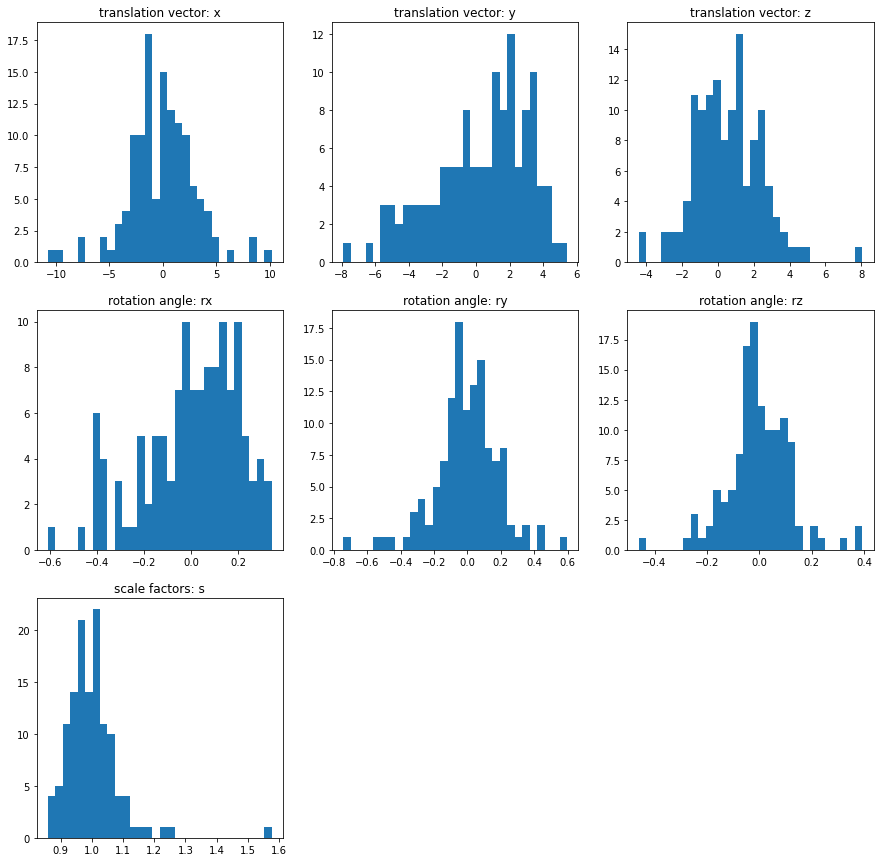

In [12]:
bins = 30
plt.figure(figsize=(15, 15))
plt.subplot(331)
plt.hist(translationVectors[:,0], bins=bins)
plt.title("translation vector: x")
plt.subplot(332)
plt.hist(translationVectors[:,1], bins=bins)
plt.title("translation vector: y")
plt.subplot(333)
plt.hist(translationVectors[:,2], bins=bins)
plt.title("translation vector: z")
plt.subplot(334)
plt.hist(rotAnglesXYZ[:,0], bins=bins)
plt.title("rotation angle: rx")
plt.subplot(335)
plt.hist(rotAnglesXYZ[:,1], bins=bins)
plt.title("rotation angle: ry")
plt.subplot(336)
plt.hist(rotAnglesXYZ[:,2], bins=bins)
plt.title("rotation angle: rz")
plt.subplot(337)
plt.hist(scaleFactors, bins=bins)
plt.title("scale factors: s")
plt.show()

## SSM PCA
$S^T = [S_1, S_2, \cdots, S_M] \quad D_i \in \mathbb{R}^{3N}$ with $N$ the number of points in each point cloud; $M<<N$

$S \in \mathbb{R}^{M \times 3N}$

$\bar{S} = \frac{1}{M} \sum_{i=1}^{M} S_i$

$D_i = S_i - \bar{S}$

$A^T = [D_1, D_2, \cdots, D_M] \quad D_i \in \mathbb{R}^{3N}$

$CovMat = \frac{1}{M-1} A^T A = P \Sigma P^T$ 

$\Sigma = diag(\lambda_1,\lambda_2,\cdots,\lambda_M,0,\cdots,0)$

直接对协方差矩阵正交分解计算量太大，求$EquCovMat = \frac{1}{M-1} A A^T$的正交分解，这两个矩阵非零特征值相同，零特征值数量不同

$\frac{1}{M-1} A A^T = P' \Sigma' P'^T ,\quad \Sigma' = diag(\lambda_1,\lambda_2,\cdots,\lambda_M)$

$\frac{1}{M-1} A^T A A^T P' = A^T P' \Sigma'$

故若$\frac{1}{M-1} A^T A$的特征值$\lambda_i(\lambda_i>0)$对应的特征向量为$p_i$，则$\frac{1}{M-1} A A^T$的特征值$\lambda_i$对应的特征向量为$p_i'=A^T p_i$

In [5]:
toothIndex = 11
saveDir = r"./data/cpdAlignedData/{}/".format(toothIndex)
# saveAlignedPointGroups2Txt(alignedPointGroups, trainPgTags, saveDir)
alignedPointGroups, alignedPgIndices = loadAlignedPointGroupsWithIndex(saveDir)

## PCA TEST

In [10]:
alignedPointVectors = np.array([pg.flatten() for pg in alignedPointGroups], dtype=np.float32)

In [11]:
alignedPointVectors.shape # (sampleNum, 3*pointNum)

(126, 4500)

In [12]:
meanTrainPointVector = alignedPointVectors.mean(axis=0)

In [13]:
normalizedTrainPointVector = alignedPointVectors - meanTrainPointVector

In [14]:
A = normalizedTrainPointVector
print("A.shape:",A.shape)

A.shape: (126, 4500)


In [ ]:
sampleNum = A.shape[0]
_eigvals, _eigvecs = np.linalg.eig(1./(sampleNum-1) * A.T @ A) #计算量太大耗时长

In [30]:
_eigvals = np.sort(_eigvals)[::-1]
np.sum(_eigvals[:20])/np.sum(_eigvals[:sampleNum])

(0.78492564+0j)

In [28]:
sampleNum = A.shape[0]
convMat = 1./(sampleNum-1) * A.T @ A #需要对A.T @ A进行主成分分析
equConvMat = 1./(sampleNum-1) * A @ A.T # A@A.T和A.T@A的特征值相同
eigVal, equEigVec = np.linalg.eig(equConvMat) # equEigVec是A @ A.T的特征值

In [29]:
reconsEquConvMat = equEigVec @ np.diag(eigVal) @ equEigVec.T
error = reconsEquConvMat - equConvMat # A @ A.T  
print("Frobenius norm of reconstruction error of A @ A.T:",np.linalg.norm(error, "fro")) # Frobenius norm of reconstruction error of A @ A.T

Frobenius norm of reconstruction error of A @ A.T: 1.1489206e-05


In [30]:
eigVal[eigVal<1e-4] = 0.0
np.all(eigVal>=0) # A@A.T对称正定矩阵特征值全部大于0

True

In [31]:
eigVal #有零说明原始数据中有重复

array([17.21029   , 13.473804  ,  8.293841  ,  7.2862988 ,  4.9682674 ,
        4.5765495 ,  4.117736  ,  3.2362869 ,  2.920376  ,  2.9624465 ,
        2.714771  ,  2.3744817 ,  2.138684  ,  2.0617814 ,  1.9005506 ,
        1.8798865 ,  1.6136558 ,  1.4938331 ,  1.440285  ,  0.        ,
        1.3800483 ,  1.339684  ,  1.3023158 ,  1.2787029 ,  1.1728375 ,
        1.1313709 ,  1.0880316 ,  1.0637218 ,  1.0276775 ,  1.0014961 ,
        0.98074627,  0.9657277 ,  0.9071263 ,  0.9029471 ,  0.8736292 ,
        0.8544115 ,  0.8144572 ,  0.7887128 ,  0.333607  ,  0.34634918,
        0.761955  ,  0.7516734 ,  0.7355039 ,  0.36787373,  0.373207  ,
        0.3856321 ,  0.39414373,  0.39804915,  0.70299673,  0.4125444 ,
        0.6924514 ,  0.68570125,  0.682693  ,  0.67220074,  0.65755236,
        0.43139988,  0.43376508,  0.4410415 ,  0.44911936,  0.46230873,
        0.4674493 ,  0.4734855 ,  0.62982994,  0.62428975,  0.4851014 ,
        0.49429885,  0.5038325 ,  0.61139226,  0.6062063 ,  0.59

In [32]:
eigVec = A.T @ equEigVec 
eigVec = eigVec / np.linalg.norm(eigVec, axis=0) # 单位化 eigVec是A.T @ A的特征值
eigVec.shape

(4590, 78)

In [33]:
reconsConvMat = eigVec @ np.diag(eigVal) @ eigVec.T
errorConvMat = reconsConvMat - convMat
print("Frobenius norm of reconstruction error of A.T @ A:",np.linalg.norm(errorConvMat, "fro")) # Frobenius norm of reconstruction error of A.T @ A

Frobenius norm of reconstruction error of A.T @ A: 2.792315e-05


In [34]:
eigOrder = sorted(range(len(eigVal)), key=lambda x:eigVal[x], reverse=True) # eigVal从大到小的索引排序
eigVal = eigVal[eigOrder]
eigVec = eigVec[:,eigOrder]

In [35]:
eigVec.shape

(4590, 78)

In [36]:
equEigVec.shape

(78, 78)

In [37]:
# u, s, vh = np.linalg.svd(A) # 奇异值分解A: u是A@A.T的特征向量 s^2是A@A.T的特征值

In [38]:
# error_svd = u @ np.diag(s**2) @ u.T - equConvMat
# print("Frobenius norm of SVD reconstruction error of A @ A.T:",np.linalg.norm(error_svd, "fro")) # Frobenius norm of SVD reconstruction error of A @ A.T

In [39]:
# s**2 - eigVal # 奇异值^2 与 特征值的计算误差

In [ ]:
numPC2Keep = 20
featureVectors = A @ eigVec[:,:numPC2Keep]
remainedInfoRatio(eigVal, numPC2Keep) # 保留前?个主成分

In [80]:
# eigVec.T @ eigVec #单位矩阵

In [46]:
featureVectors.shape

(78, 50)

In [47]:
trainErrorAfterPCA = A - featureVectors @ eigVec[:,:numPC2Keep].T

In [48]:
trainErrorAfterPCA.shape

(78, 4590)

In [49]:
np.linalg.norm(trainErrorAfterPCA, axis=1)

array([4.5373855 , 4.067312  , 4.9536004 , 1.9169651 , 2.1935298 ,
       4.1330934 , 2.5862355 , 3.356179  , 3.8078196 , 2.8407016 ,
       4.5057178 , 1.0725849 , 2.5961602 , 4.223796  , 3.8711038 ,
       1.0476341 , 2.9455686 , 4.0087276 , 4.0778213 , 1.5395563 ,
       2.1628075 , 4.8470488 , 4.79366   , 2.8698573 , 2.9125593 ,
       4.8871    , 4.616288  , 4.987727  , 2.0032945 , 2.4764764 ,
       4.112472  , 1.456289  , 4.663321  , 4.8866777 , 4.308562  ,
       4.4416113 , 3.8360837 , 4.703391  , 4.550815  , 4.3307476 ,
       3.685613  , 1.0372249 , 1.5690658 , 4.042269  , 0.62417483,
       4.8260045 , 2.6198056 , 3.2714992 , 2.4200196 , 2.7154415 ,
       3.2081254 , 4.98518   , 2.1262758 , 3.1160438 , 2.7171164 ,
       3.337334  , 1.3503798 , 1.9772766 , 3.0582414 , 3.574003  ,
       4.078317  , 0.44320405, 4.0071764 , 5.1112776 , 3.0641193 ,
       4.437794  , 2.2120557 , 3.7954173 , 1.7586478 , 5.2209725 ,
       4.191918  , 4.8671618 , 1.2422935 , 4.9894967 , 2.37332

In [50]:
np.linalg.norm(trainErrorAfterPCA, axis=1) / np.linalg.norm(alignedPointVectors, axis=1)

array([0.00679821, 0.00609438, 0.00742154, 0.00287382, 0.00328678,
       0.00619517, 0.00387474, 0.0050287 , 0.00570486, 0.00425639,
       0.00675047, 0.00160834, 0.00389028, 0.00632869, 0.00580097,
       0.00156954, 0.00441366, 0.00600575, 0.00611097, 0.00230699,
       0.00324075, 0.0072635 , 0.00718295, 0.00430056, 0.00436377,
       0.00732177, 0.00691711, 0.00747304, 0.00300303, 0.00370971,
       0.00616229, 0.00218341, 0.00698627, 0.00732053, 0.00645515,
       0.00665532, 0.00574824, 0.0070476 , 0.00681929, 0.00649001,
       0.00552221, 0.00155387, 0.00235093, 0.0060567 , 0.00093739,
       0.00723075, 0.00392544, 0.00490351, 0.00362743, 0.0040697 ,
       0.00480724, 0.0074692 , 0.00318709, 0.00466861, 0.00407091,
       0.00500014, 0.00202337, 0.00296267, 0.00458262, 0.00535515,
       0.00611121, 0.00066497, 0.00600517, 0.00765841, 0.00459138,
       0.00664861, 0.00331456, 0.00568834, 0.00263676, 0.00782295,
       0.00627965, 0.00729105, 0.00186262, 0.00747513, 0.00355

## Reconstruction

In [ ]:
eigVal, eigVec, A, meanTrainPointVector = getEigValVecOfSSMByPCA(alignedPointGroups)
numPC2Keep = 20
featureVectors = A @ eigVec[:,:numPC2Keep]
print("Num of PCA component used: {}, cumulative explained variance:{:.4f}%".format(numPC2Keep,100*remainedInfoRatio(eigVal, numPC2Keep))) # 保留前?个主成分
visualizeCompactnessOfSSM(eigVal)

Num of PCA component used: 10, cumulative explained variance:85.5384%


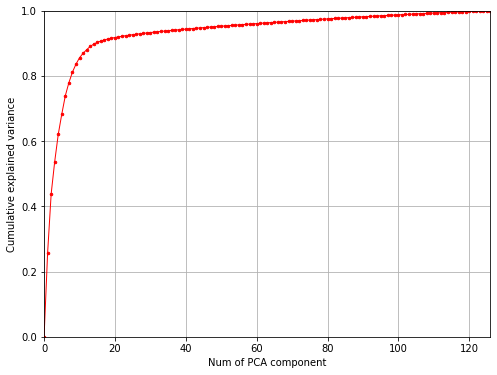

In [29]:
toothIndex = 11
saveDirGp = r"./data/cpdGpAlignedData/{}/".format(toothIndex)
# saveAlignedPointGroups2Txt(alignedPointGroups, trainPgTags, saveDir)
alignedPointGroups, alignedPgIndices = loadAlignedPointGroupsWithIndex(saveDirGp)

eigVal, eigVec, A, meanTrainPointVector = getEigValVecOfSSMByPCA(alignedPointGroups)
numPC2Keep = 10
featureVectors = A @ eigVec[:,:numPC2Keep]
print("Num of PCA component used: {}, cumulative explained variance:{:.4f}%".format(numPC2Keep,100*remainedInfoRatio(eigVal, numPC2Keep))) # 保留前?个主成分
visualizeCompactnessOfSSM(eigVal)

In [6]:
def alignTestPointGroups(refPG, testPGs, tolerance=1e-4, max_iter=100):
    testScales = []
    testRotMats = []
    testTransVecs = []
    correTestPGs = []
    correTransformedTestPGs = []
    transformedTestPGs = []
    refPG = refPG.astype(np.double)
    for i,testPG in enumerate(testPGs):
        correY, correTY, TY, (s,R,t) = alignPointsByRigidRegistration(refPG, testPG, step=i+1,max_step=len(testPGs), tolerance=tolerance, max_iter=max_iter)
        testScales.append(s)
        testRotMats.append(R)
        testTransVecs.append(t)
        correTestPGs.append(correY)
        correTransformedTestPGs.append(correTY)
        transformedTestPGs.append(TY)
    return correTestPGs, correTransformedTestPGs, transformedTestPGs, testScales, testRotMats, testTransVecs

In [18]:
testPGs = sortedTestPGs
refPG = meanTrainPointVector.reshape(-1,3)
# correTestPGs, correTransformedTestPGs, transformedTestPGs, testScales, testRotMats, testTransVecs = alignTestPointGroups(refPG, testPGs, tolerance=1e-4, max_iter=100)

---------- Finish 1/9 ----------
---------- Finish 2/9 ----------
---------- Finish 3/9 ----------
---------- Finish 4/9 ----------
---------- Finish 5/9 ----------
---------- Finish 6/9 ----------
---------- Finish 7/9 ----------
---------- Finish 8/9 ----------
---------- Finish 9/9 ----------


In [19]:
# alignedTestVectors = np.array([pg.flatten() for pg in correTransformedTestPGs]) # shape=(testSampleNum, 3*pointNum)
# normalizedTestPointVectors = alignedTestVectors - meanTrainPointVector
# featureVecs = normalizedTestPointVectors @ eigVec[:,:numPC2Keep]

In [20]:
eigVec[:,:numPC2Keep].shape

(4500, 50)

In [ ]:
# reconstructAlignedTestPointVectors = (featureVecs @ eigVec[:,:numPC2Keep].T + meanTrainPointVector) #重建的缩放刚性变换得到的测试点云
# reconstructAlignedTestPGs = [x.reshape(-1,3) for x in reconstructAlignedTestPointVectors] # 还需要inv平移，inv旋转，inv缩放
# reconstructInitTestPGs = [1./s * (alignedTestPG - t) @ np.linalg.inv(R) for s,R,t,alignedTestPG in zip(testScales,testRotMats, testTransVecs, reconstructAlignedTestPGs)]#逆缩放刚性变换得到重建的原始的点云

In [44]:
testSavePath = os.path.join(saveDir,"test")
if not os.path.exists(testSavePath):
    os.makedirs(testSavePath)

In [45]:
savedTestPGFiles = [os.path.join(testSavePath, tag+".txt") for tag in sortedTestTags] # 读取保存的重建的测试点云
reconstructInitTestPGs = [np.loadtxt(f) for f in savedTestPGFiles]
savedCorreInitTestPGFiles = [os.path.join(testSavePath, "corre_init_{}.txt".format(tag)) for tag in sortedTestTags] # 读取原始的测试点云（下采样后的）
correTestPGs = [np.loadtxt(f) for f in savedCorreInitTestPGFiles]

In [46]:
testErrors = np.array([(x-xPred).flatten() for x,xPred in zip(correTestPGs,reconstructInitTestPGs)])
initCenteredTestPointVectors = np.array([(x-x.mean(axis=0)).flatten() for x in correTestPGs])
print("error: ", np.linalg.norm(testErrors, axis=1, ord=2))
print("relative error: ", np.linalg.norm(testErrors, axis=1, ord=2) / np.linalg.norm(initCenteredTestPointVectors, axis=1, ord=2))

error:  [ 8.62421324  8.48483025  9.58357265  8.97988838  9.31688444  9.47594869
 11.97105841]
relative error:  [0.05011124 0.04671869 0.05258071 0.04731998 0.05051747 0.04936262
 0.05848453]


Mean Corresponding Point Distance: 0.2224 mm
Max Corresponding Point Distance: 1.1131 mm
Min Corresponding Point Distance: 0.0078 mm


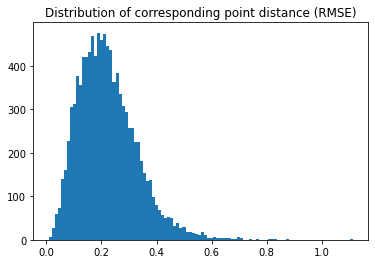

In [47]:
pointErrors = np.array([x-xPred for x,xPred in zip(correTestPGs,reconstructInitTestPGs)])
pointDists = np.linalg.norm(pointErrors, axis=2, ord=2)

print("Mean Corresponding Point Distance: {:.4f} mm".format(pointDists.mean()))
print("Max Corresponding Point Distance: {:.4f} mm".format(pointDists.max()))
print("Min Corresponding Point Distance: {:.4f} mm".format(pointDists.min()))

plt.hist(pointDists.flatten(), bins=100)
plt.title("Distribution of corresponding point distance (RMSE)")
plt.show()

In [48]:
initCenteredTestPGs = np.array([x-x.mean(axis=0) for x in correTestPGs])
point2CentroidDists = np.linalg.norm(initCenteredTestPGs, axis=2, ord=2)
relPointDists = pointDists / point2CentroidDists
print("Mean Corresponding Point Relative Distance: {:.4f} ".format(relPointDists.mean()))
print("Max Corresponding Point Relative Distance: {:.4f} ".format(relPointDists.max()))
print("Min Corresponding Point Relative Distance: {:.4f} ".format(relPointDists.min()))

Mean Corresponding Point Relative Distance: 0.0511 
Max Corresponding Point Relative Distance: 0.4394 
Min Corresponding Point Relative Distance: 0.0013 


In [23]:
# # 保存重建的测试点云（按配准参数进行复位）
# for testTag,pg in zip(sortedTestTags, reconstructInitTestPGs):
#     np.savetxt(os.path.join(testSavePath,"{}.txt".format(testTag)), pg)

## Animation

In [7]:
def generateOnePCAnimationPointGroups(eigVec,eigVal,meanPointVector,pcIndex=0,animationSampleNum=100):
    pc = eigVal[pcIndex]
    pcFeatureVecs = np.linspace(-3.*np.sqrt(pc), 3.*np.sqrt(pc), animationSampleNum)
    pcAnimationPointVectors = meanPointVector + np.multiply(pcFeatureVecs[:,None],eigVec[:,pcIndex])
    pcAnimationPointGroups = [pcAnimationPointVectors[i,...].reshape(-1,3) for i in range(animationSampleNum)]
    return pcAnimationPointGroups

In [8]:
def meshAnimation(meshes, window_name):
    # 三角面片动画
    vis = o3d.visualization.Visualizer()
    #创建播放窗口
    vis.create_window(window_name=window_name, width=800, height=600, left=50, top=50)
    to_reset = True
    # vis.get_render_option().mesh_show_wireframe = True
    # vis.get_render_option().mesh_show_back_face = False
    # vis.get_render_option().mesh_shade_option = o3d.visualization.MeshShadeOption.Color
    # vis.get_render_option().light_on = True
    tempMesh = o3d.geometry.TriangleMesh()
    vis.add_geometry(tempMesh)
    for msh in meshes:
        tempMesh.vertices = msh.vertices
        tempMesh.triangles = msh.triangles
        tempMesh.vertex_normals = msh.vertex_normals
        # tempMesh.triangle_normals = msh.triangle_normals
        # tempMesh.textures = msh.textures
        vis.update_geometry(tempMesh)
        if to_reset:
            vis.reset_view_point(True)
            to_reset = False
        vis.poll_events()
        vis.update_renderer()
        time.sleep(0.1)
    vis.destroy_window()

In [9]:
def pointCloudAnimation(pointGroups, window_name):
    #点云动画
    vis = o3d.visualization.Visualizer()
    #创建播放窗口
    vis.create_window(window_name=window_name, width=800, height=600, left=50, top=50)
    pcd = o3d.geometry.PointCloud()
    to_reset = True
    vis.add_geometry(pcd)

    for pg in pointGroups:
        pcd.points = o3d.utility.Vector3dVector(pg)
        vis.update_geometry(pcd)
        if to_reset:
            vis.reset_view_point(True)
            to_reset = False
        vis.poll_events()
        vis.update_renderer()
        time.sleep(0.1)

    vis.destroy_window()

In [10]:
pcIndexToAnimate = 0
pcAnimationPointGroups = generateOnePCAnimationPointGroups(eigVec,eigVal,meanTrainPointVector,pcIndexToAnimate)

In [11]:
#点云动画
pointCloudAnimation(pcAnimationPointGroups, window_name="PC_{}".format(pcIndexToAnimate))

In [ ]:
# 计算水密三角面片
pcAnimationO3dMeshes = [surfaceVertices2WatertightO3dMesh(pcAnimationPointGroups[i], False) for i in range(animationSampleNum)]

In [170]:
# 三角面片动画
meshAnimation(pcAnimationO3dMeshes, window_name="PC_{}".format(pcIndexToAnimate))

## mode visualization

Num of PCA component used: 10, cumulative explained variance:85.5384%
export modes obj for tooth:  11
Num of PCA component used: 10, cumulative explained variance:86.1690%
export modes obj for tooth:  12
Num of PCA component used: 10, cumulative explained variance:85.7989%
export modes obj for tooth:  13
Num of PCA component used: 10, cumulative explained variance:83.0922%
export modes obj for tooth:  14
Num of PCA component used: 10, cumulative explained variance:82.7793%
export modes obj for tooth:  15
Num of PCA component used: 10, cumulative explained variance:79.0620%
export modes obj for tooth:  16
Num of PCA component used: 10, cumulative explained variance:84.7092%
export modes obj for tooth:  17


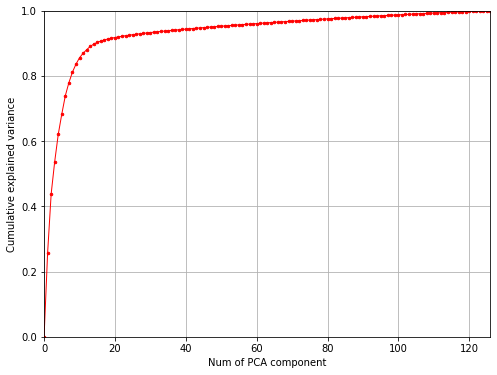

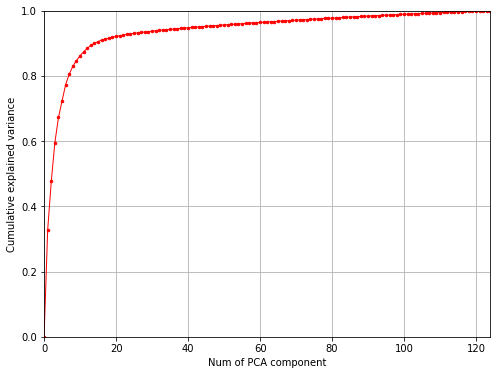

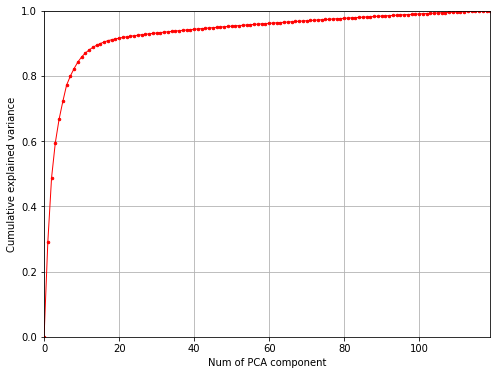

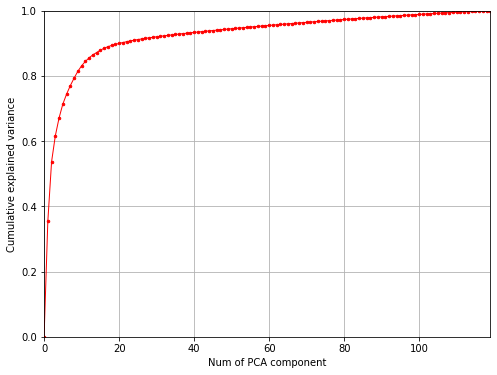

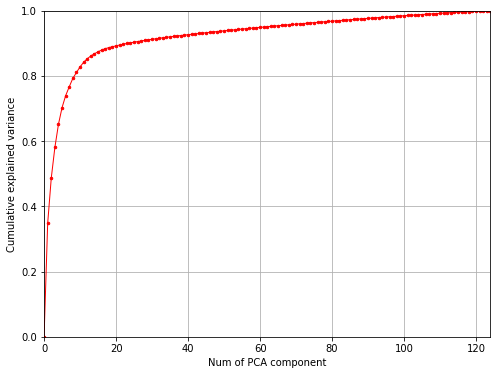

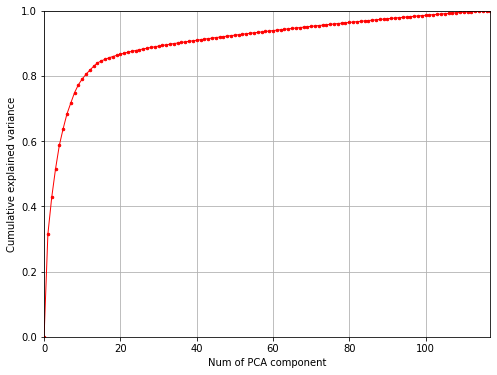

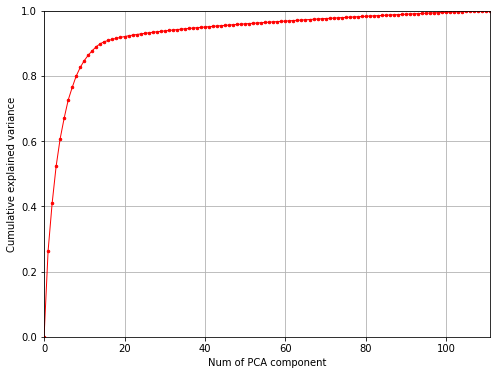

In [2]:
for toothIndex in range(11,18):
    # toothIndex = 11
    saveDirGp = r"./data/cpdGpAlignedData/{}/".format(toothIndex)
    # saveAlignedPointGroups2Txt(alignedPointGroups, trainPgTags, saveDir)
    alignedPointGroups, alignedPgIndices = loadAlignedPointGroupsWithIndex(saveDirGp)

    eigVal, eigVec, A, meanTrainPointVector = getEigValVecOfSSMByPCA(alignedPointGroups)
    numPC2Keep = 10
    featureVectors = A @ eigVec[:,:numPC2Keep]
    print("Num of PCA component used: {}, cumulative explained variance:{:.4f}%".format(numPC2Keep,100*remainedInfoRatio(eigVal, numPC2Keep))) # 保留前?个主成分
    visualizeCompactnessOfSSM(eigVal)

    
    save_path = r"./dataWithPhoto/"

    mesh_mean = utils.surfaceVertices2WatertightO3dMesh(meanTrainPointVector.reshape(-1,3), False)
    utils.exportTriMeshObj(np.asarray(mesh_mean.vertices), np.asarray(mesh_mean.triangles), objFile=os.path.join(save_path,"./t{}_mesh_mean.obj".format(toothIndex)))
    for pcIndex in [0,1,2]:
        pVec_left_drift_3sigma = meanTrainPointVector - 3 * np.sqrt(eigVal[pcIndex]) * eigVec[:,pcIndex]
        pVec_right_drift_3sigma = meanTrainPointVector + 3 * np.sqrt(eigVal[pcIndex]) * eigVec[:,pcIndex]

        mesh_left_drift_3sigma = utils.surfaceVertices2WatertightO3dMesh(pVec_left_drift_3sigma.reshape(-1,3), False)
        mesh_right_drift_3sigma = utils.surfaceVertices2WatertightO3dMesh(pVec_right_drift_3sigma.reshape(-1,3), False)

        utils.exportTriMeshObj(np.asarray(mesh_left_drift_3sigma.vertices), np.asarray(mesh_left_drift_3sigma.triangles), objFile=os.path.join(save_path,"./t{}_mode{}-3sigma.obj".format(toothIndex,pcIndex+1)))
        utils.exportTriMeshObj(np.asarray(mesh_right_drift_3sigma.vertices), np.asarray(mesh_right_drift_3sigma.triangles), objFile=os.path.join(save_path,"./t{}_mode{}+3sigma.obj".format(toothIndex,pcIndex+1)))
    print("export modes obj for tooth: ", toothIndex)